Testing with 1 doctors..
Testing with 2 doctors..
Testing with 3 doctors..
Testing with 4 doctors..
Testing with 5 doctors..


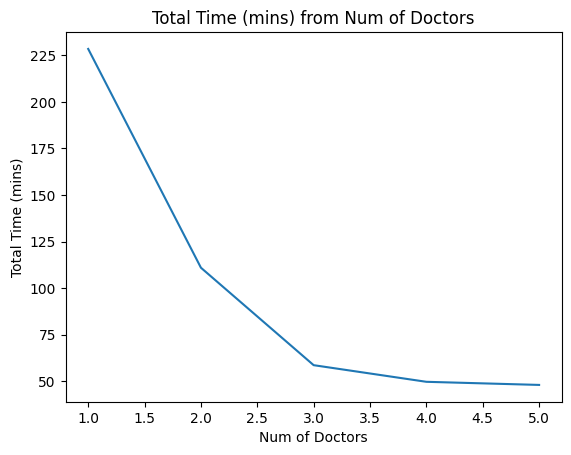

In [6]:
import simpy
import random
import matplotlib.pyplot as plt

def patients_generator(env: simpy.Environment, patient_iat: int, registration_mt: int, surgery_mt: int, booking_mt: int, booking_test_prob: float, receptionist: simpy.Resource, doctor: simpy.Resource):
    p_id = 0
    while True:
        patient = patient_activity_generator(env, p_id, registration_mt, surgery_mt, booking_mt, booking_test_prob, receptionist, doctor)
        env.process(patient)
        t = random.expovariate(1.0 / patient_iat)
        yield env.timeout(t)
        p_id += 1

def receptionist_calls_generator(env: simpy.Environment, call_iat: int, call_mt: int, receptionist: simpy.Resource):
    while True:
        call = call_activity_generator(env, call_mt, receptionist)
        env.process(call)
        t = random.expovariate(1.0 / call_iat)
        yield env.timeout(t)      

def patient_activity_generator(env: simpy.Environment, p_id: int, registration_mt: int, surgery_mt: int, booking_mt: int, booking_test_prob: float, receptionist: simpy.Resource, doctor: simpy.Resource):
    global registration_waiting_times_list
    global surgery_waiting_times_list
    global booking_waiting_times_list
    global system_times_list
    
    time_entered_reg_queue = env.now
    # print(f'Patient {p_id} entered REG queue at {time_entered_reg_queue}')

    with receptionist.request() as req:
        yield req
        time_left_reg_queue = env.now
        waiting_time = time_left_reg_queue - time_entered_reg_queue
        registration_waiting_times_list.append(waiting_time)
        # print(f'Patient {p_id} left REG queue at {time_left_reg_queue}, waiting time = {waiting_time}')

        t = random.expovariate(1.0 / registration_mt)
        yield env.timeout(t)

        time_finished_registration = env.now
        # print(f'Patient {p_id} finished registration at {time_finished_registration}')

    
    time_entered_gp_queue = env.now
    # print(f'Patient {p_id} entered GP queue at {time_entered_gp_queue}')
    with doctor.request() as req:
        yield req
        time_left_gp_queue = env.now
        waiting_time = time_left_gp_queue - time_entered_gp_queue
        surgery_waiting_times_list.append(waiting_time)
        # print(f'Patient {p_id} left GP queue at {time_left_reg_queue}, waiting time = {waiting_time}')

        t = random.expovariate(1.0 / surgery_mt)
        yield env.timeout(t)

        time_finished_surgery = env.now
        # print(f'Patient {p_id} finished surgery at {time_finished_surgery}')

    decide_booking_branch = random.uniform(0, 1)
    if decide_booking_branch < booking_test_prob:
        time_entered_booking_queue = env.now
        # print(f'Patient {p_id} entered BOOK queue at {time_entered_booking_queue}')
        with receptionist.request() as req:
            yield req
            
            time_left_booking_queue = env.now
            waiting_time = time_left_booking_queue - time_entered_booking_queue
            booking_waiting_times_list.append(waiting_time)
            # print(f'Patient {p_id} left BOOK queue at {time_left_booking_queue}, waiting time = {waiting_time}')
    
            t = random.expovariate(1.0 / booking_mt)
            yield env.timeout(t)
    
            time_finished_booking = env.now
            # print(f'Patient {p_id} finished booking at {time_finished_booking}')
            if env.now >= warmup_period:
                system_times_list.append(time_finished_booking - time_entered_reg_queue)
    else:
        system_times_list.append(time_finished_surgery - time_entered_reg_queue)

def call_activity_generator(env: simpy.Environment, call_mt: int, receptionist: simpy.Resource):
    with receptionist.request() as req:
        yield req
        t = random.expovariate(1.0 / call_mt)
        yield env.timeout(t)

verbose = False
number_runs = 100
doctors_x = [1, 2, 3, 4,5 ]
sys_time_y = []

for num_doctors in doctors_x:
    print(f'Testing with {num_doctors} doctors..')
    run_sys_times = []
    
    for run_id in range(number_runs):
        num_receptionists = 1
        env = simpy.Environment()
        
        receptionist = simpy.Resource(env, capacity=num_receptionists)
        doctor = simpy.Resource(env, capacity=num_doctors)
        
        registration_waiting_times_list: list[int] = []
        surgery_waiting_times_list: list[int] = []
        booking_waiting_times_list: list[int] = []
        
        system_times_list: list[int] = []
        
        patient_iat = 3
        registration_mt = 2
        surgery_mt = 8
        booking_mt = 4

        call_iat = 60
        call_mt = 4

        warmup_period = 3*60
        collection_period = 8*60
        
        booking_test_prob = 0.25
        
        env.process(patients_generator(env, patient_iat, registration_mt, surgery_mt, booking_mt, booking_test_prob, receptionist, doctor))
        env.process(receptionist_calls_generator(env, call_iat, call_mt, receptionist))
        env.run(until=(warmup_period + collection_period))
        
        
        
        mean_registration_waiting_time = sum(registration_waiting_times_list) / len(registration_waiting_times_list)
        mean_surgery_waiting_time = sum(surgery_waiting_times_list) / len(surgery_waiting_times_list)
        mean_booking_waiting_time = sum(booking_waiting_times_list) / len(booking_waiting_times_list)
        mean_system_time = sum(system_times_list) / len(system_times_list)
    
        run_sys_times.append(mean_system_time)
        
        
        if verbose:
            print('\n\nSystem Waiting Times:\n')
            print(f'Mean Registration Waiting Time: {mean_registration_waiting_time} mins, n = {len(registration_waiting_times_list)}')
            print(f'Mean Surgery Waiting Time: {mean_surgery_waiting_time} mins, n = {len(surgery_waiting_times_list)}')
            print(f'Mean Booking Waiting Time: {mean_booking_waiting_time} mins, n = {len(booking_waiting_times_list)}')
            print('\nSystem Time:\n')
            print(f'Mean System Time: {mean_system_time} mins, n = {len(system_times_list)}')
            
            fig, ax = plt.subplots()
            
            
            labels = ['System', 'REG time', 'GP time', 'Book time']
            times  = [mean_system_time, mean_registration_waiting_time, mean_surgery_waiting_time, mean_booking_waiting_time]
            
            ax.bar(labels, times)
            ax.set_ylabel('Time (mins)')
            ax.set_title(f'Patient Times w/ {num_doctors} doctors')
            
            
            plt.show()

    sys_time_y.append(sum(run_sys_times) / len(run_sys_times))

if len(doctors_x) > 1:
    fig, ax = plt.subplots()
    
    ax.plot(doctors_x, sys_time_y)
    ax.set_ylabel('Total Time (mins)')
    ax.set_xlabel('Num of Doctors')
    ax.set_title('Total Time (mins) from Num of Doctors')
    
    plt.show()

In [7]:
print('Some world!')

Some world!
